# Logistic Regression Modeling

Aaron Balke

December 15th, 2023

# Part 1: Research Question

## Question

For this analysis, my research question is, "Does High Blood Pressure correlate to any other specific conditions?".

## Analysis Goals

Using a logistic regression model to answer our research question will give our organization/hospital the ability to predict patient cardiovascular requirements. This will allow us to make informed resource management decisions, to efficiently and effectively treat patients, and give the patients the ability to plan and estimate financially.

# Part 2: Method Justification

## Assumptions

1. Binary Dependent Variable: The Dependent Variable has to be a discrete binary option. It cannot be a continuous variable or a categorical variable with multiple options.

2. Relationship: The independent and dependent variables have to have a relationship - without a relationship, there is no point in including the variable.

3. No or little multicollinearity: Perfect Relationships between exploratory variables should be avoided. Multicollinearity leads to Type II errors (False Negatives) - we accept the Null Hypothesis when it should be rejected.

4. Independence: Each variable is independent of all other variables

## Tool Benefits

Python is the chosen programming language. This is because it has:
1. Strong module/library support: For our analysis, we will need a method of calculating the variance inflation factor (VIF). By using Python, we can easily access the VIF method provided by the statsmodel library, this would not have been possible as simply in another language.
2. Integration with Jupyter Notebook: Python is the default language supported by Jupyter Notebook, giving us access to the features of Jupyter Notebook, particularly checkpoints, which are saved file states, giving us access to analysis states without rerunning intense calculations on every view. This will be handy when we are running OLS Regression, we will only want to run a model once, save its state, and then move to the next point - not rerun the model every time we want to move on.

## Technique Explanation

For our research questions, we need to model the relationships between a discrete boolean variable, High Blood Pressure, against continuous and categorical indepedent variables - which Multiple Logistic Regression is used for. High Blood is provided as a discrete categorical option, "Yes" or "No", not a continuous variable, making it work as our dependent variable for analysis.

# Part III: Data Preparation

## Data Cleaning

The main goal of this data cleaning is to remove all unnecessary information from the dataset. Since we are only comparing High Blood Pressure to specific conditions, location data, and survey data will not be needed. Additionally, we will run duplicate checks, and missing value checks, then delete all records that are duplicates or missing values.

Steps:
1. Remove Duplicates
2. Handle Missing Values
3. Remove Usused Features

In [1]:
# Standard Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels imports for Logistic Regression Model and Evaluation Methods
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sklearn imports for Logistic Regression Model and Evaluation Methods
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Import Data
df = pd.read_csv('./medical_clean.csv')

In [2]:
# Get Shape of new dataframe of only duplicate values
df[df.duplicated()].shape

(0, 50)

In [3]:
# Aggregate NaN Values, filter aggregates > 0, returns # records with NaN values
nullity = df.isna().sum()
nullity[~(nullity == 0)].shape

(0,)

In [4]:
# Remove Unused Features
df.drop(
    columns=['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip', 'Lat', 'Lng', 'Area',
             'Population', 'TimeZone', 'Job', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'],
    inplace=True)

## Summary Statistics

Summary Statistics are split into 3 sections: The Dependent Variable, The Continuous Independent Variables, and The Categorical/Qualitative Independent Variables. This is done since they each have their descriptive methods.

In [5]:
# Get Summary Stats of Dependent Variable
df['HighBlood'].value_counts()

No     5910
Yes    4090
Name: HighBlood, dtype: int64

In [6]:
# Get Summary Stats of Continuous Independent Variables

features_continuous = ["Children", "Age", "Income", "VitD_levels", "Doc_visits", "Full_meals_eaten", "vitD_supp", "Initial_days",
    "Additional_charges", 'TotalCharge']

df[features_continuous].describe()

,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,Additional_charges,TotalCharge
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2.097200,53.511700,40490.495160,17.964262,5.012200,1.001400,0.398900,34.455299,12934.528587,5312.172769
std,2.163659,20.638538,28521.153293,2.017231,1.045734,1.008117,0.628505,26.309341,6542.601544,2180.393838
min,0.000000,18.000000,154.080000,9.806483,1.000000,0.000000,0.000000,1.001981,3125.703000,1938.312067
25%,0.000000,36.000000,19598.775000,16.626439,4.000000,0.000000,0.000000,7.896215,7986.487755,3179.374015
50%,1.000000,53.000000,33768.420000,17.951122,5.000000,1.000000,0.000000,35.836244,11573.977735,5213.952000
75%,3.000000,71.000000,54296.402500,19.347963,6.000000,2.000000,1.000000,61.161020,15626.490000,7459.699750
max,10.000000,89.000000,207249.100000,26.394449,9.000000,7.000000,5.000000,71.981490,30566.070000,9180.728000


In [7]:
# Get Summary Stats of Qualitative Independent Variables
features_categorical = ['Marital', 'Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'Overweight',
                        'Stroke', 'Complication_risk', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
                        'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis',
                        'Asthma', 'Services']

for column in features_categorical:
    print(f"{df[column].name} Unique Values:")    
    print(f"{df[column].value_counts()}\n")

Marital Unique Values:
Widowed          2045
Married          2023
Separated        1987
Never Married    1984
Divorced         1961
Name: Marital, dtype: int64

Gender Unique Values:
Female       5018
Male         4768
Nonbinary     214
Name: Gender, dtype: int64

ReAdmis Unique Values:
No     6331
Yes    3669
Name: ReAdmis, dtype: int64

Soft_drink Unique Values:
No     7425
Yes    2575
Name: Soft_drink, dtype: int64

Initial_admin Unique Values:
Emergency Admission      5060
Elective Admission       2504
Observation Admission    2436
Name: Initial_admin, dtype: int64

Overweight Unique Values:
Yes    7094
No     2906
Name: Overweight, dtype: int64

Stroke Unique Values:
No     8007
Yes    1993
Name: Stroke, dtype: int64

Complication_risk Unique Values:
Medium    4517
High      3358
Low       2125
Name: Complication_risk, dtype: int64

Arthritis Unique Values:
No     6426
Yes    3574
Name: Arthritis, dtype: int64

Diabetes Unique Values:
No     7262
Yes    2738
Name: Diabetes, dtype

## Distribution Visualizations

### Univariate Distributions

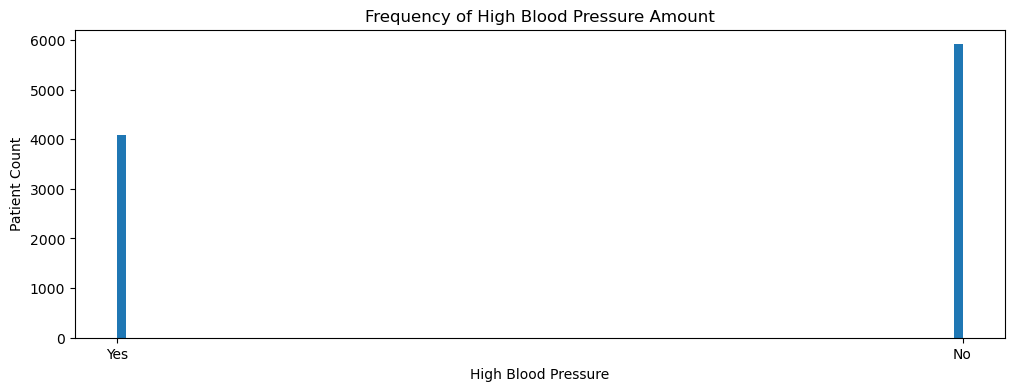

In [8]:
# Dependent Variable (HighBlood) Visualization
plt.figure(figsize=(12,4))
plt.hist(data=df, x = "HighBlood", bins=100)
plt.xlabel("High Blood Pressure")
plt.ylabel("Patient Count");
plt.title("Frequency of High Blood Pressure Amount")
plt.show()

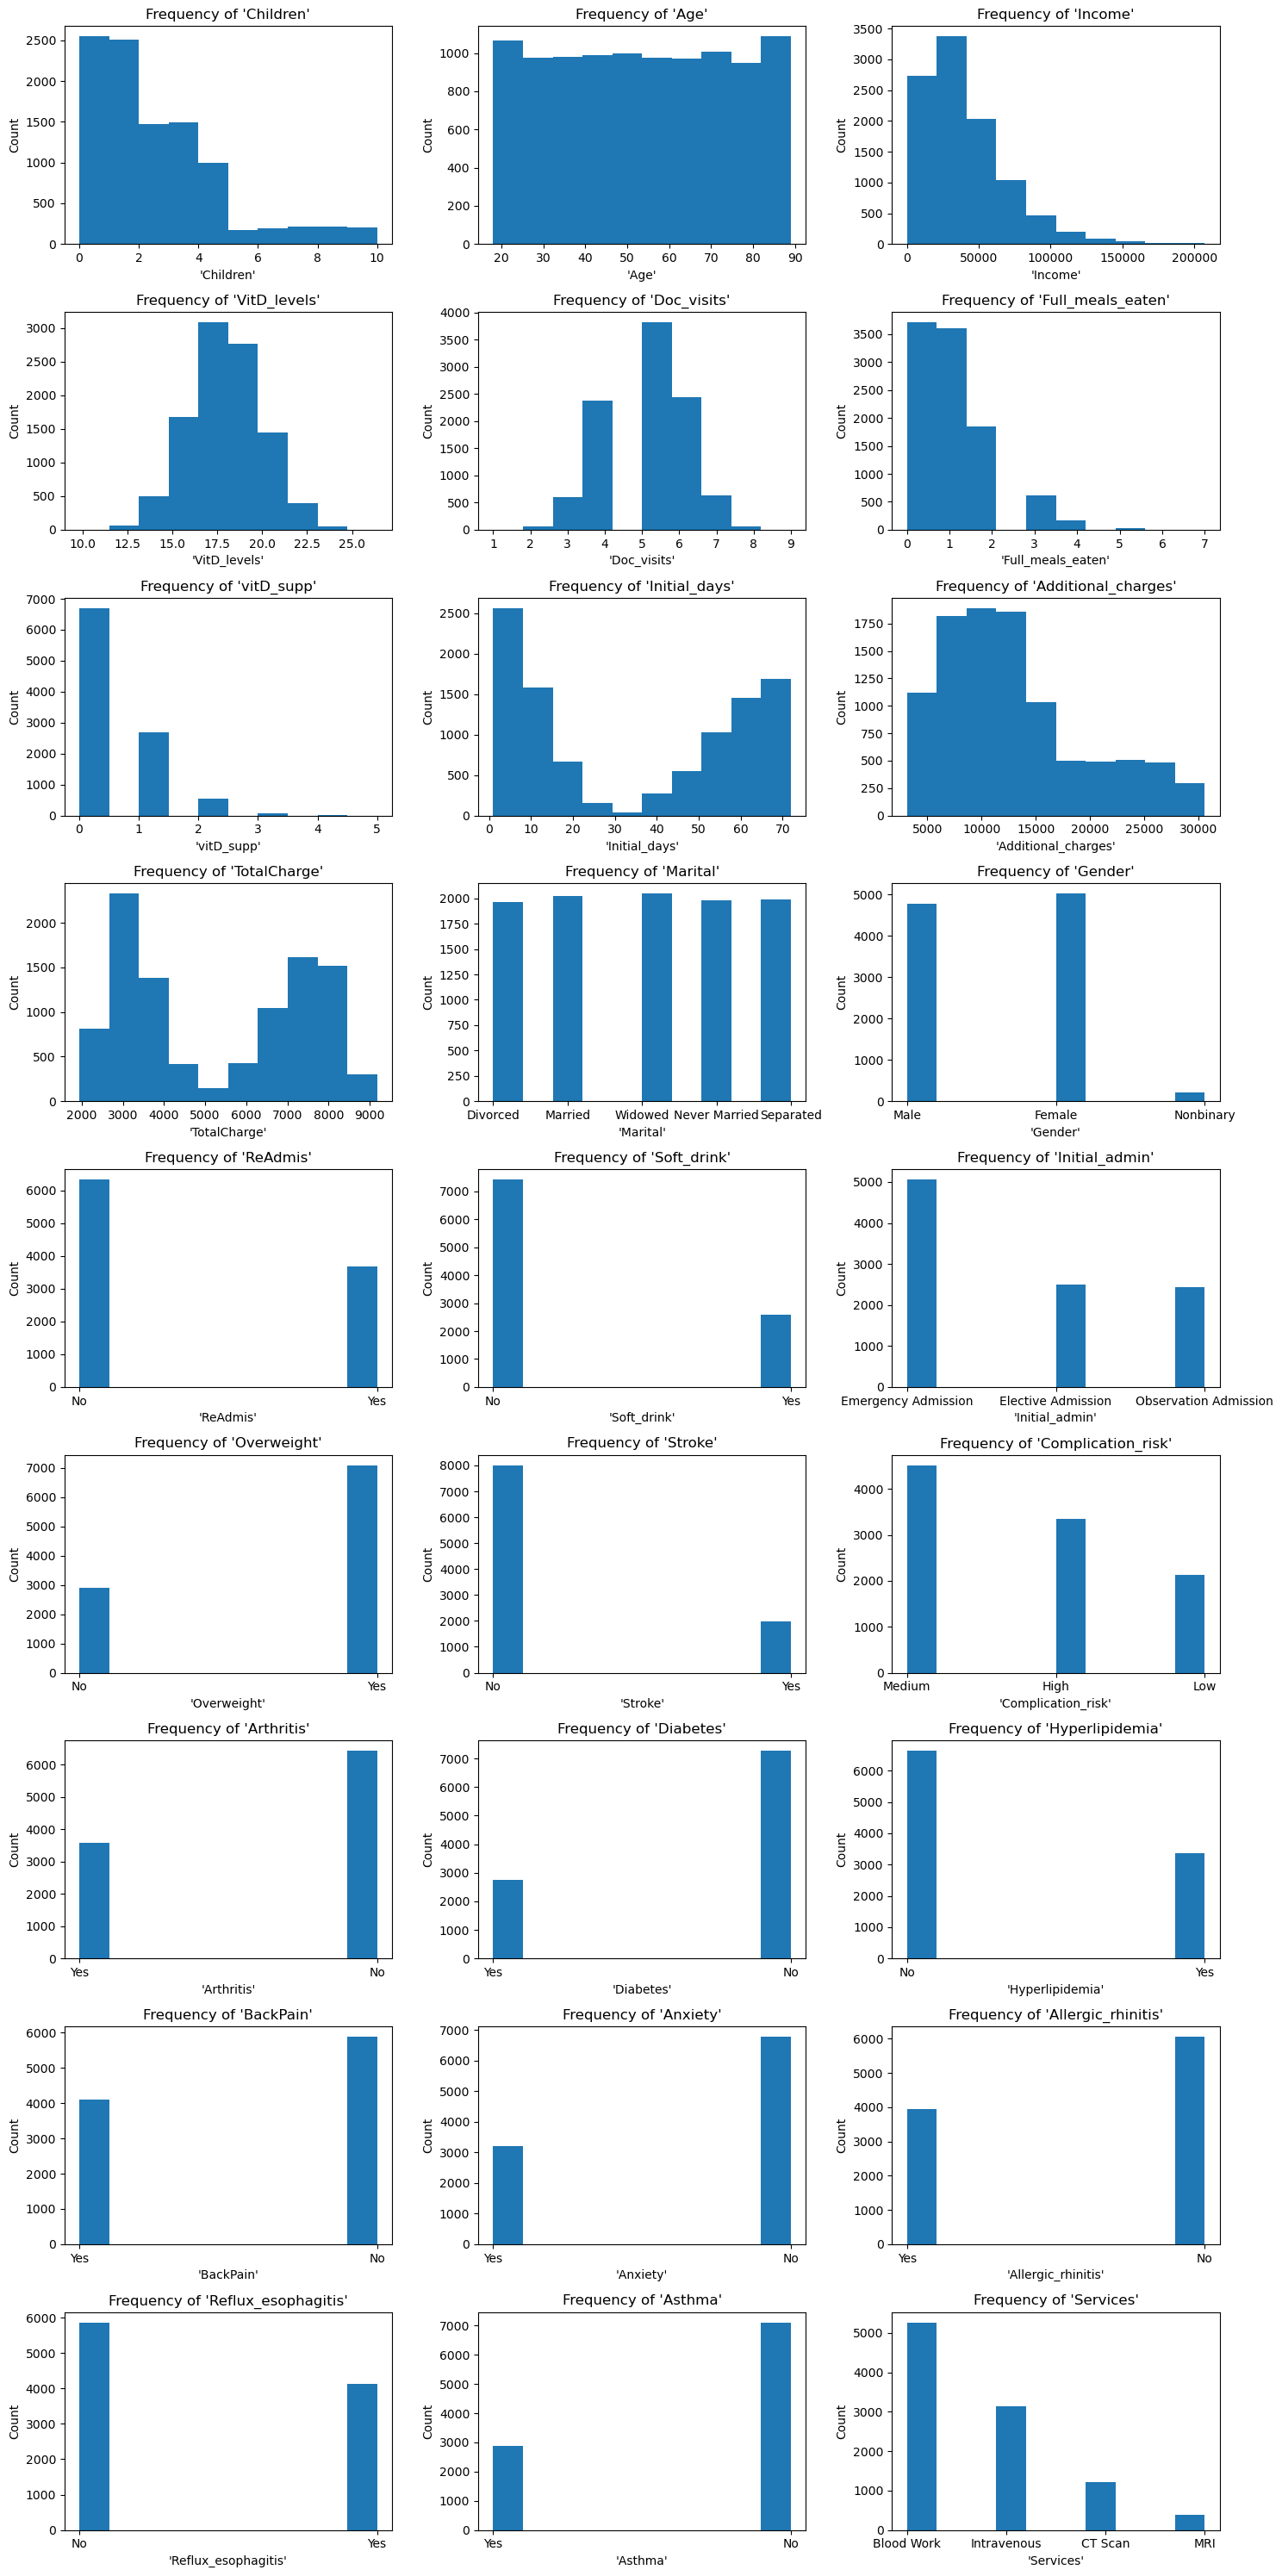

In [9]:
# Univariate Histograms for Independent Variables

num_cols = 3

var_independent = features_continuous + features_categorical

_, axs = plt.subplots(math.ceil(len(var_independent) / num_cols), num_cols, figsize=(15, 30), tight_layout=True)

for i, var in enumerate(var_independent):
    axs[i // num_cols, i % num_cols].hist(data=df, x = var, bins=10)
    name = f'{var=}'.split('=')[1]
    axs[i // num_cols, i % num_cols].set_xlabel(name)
    axs[i // num_cols, i % num_cols].set_ylabel("Count");
    axs[i // num_cols, i % num_cols].set_title(f"Frequency of {name}")

plt.show()

Univariate Observations:
1. Additional Charges have a steep falloff at 15,000.
2. Age is fairly level. I would have thought there would be more elderly getting hospitalized than 20-year-olds.
3. It appears all types of martial status are equal in frequency. This is completely different from the US average, where notably Married is almost 50%, and separated is only 2% (US Census Bureau)

### Bivariate Distributions are below Data Transformation. Dummy Variables / Conversions to Booleans make visualizations easier.

## Data Transformation

The first step to transform our data for our analysis will be to convert features to the correct types:
1. Convert Object Data Types to Categorical for Marital, Gender, Initial_admin, Complication_risk, and Services.
2. Convert Boolean Data Types to Integers for ReAdmis, Soft_drink, Stroke, Overweight, Arthritis, Diabetes, Hyperlipidemia, BackPain, Anxiety, Allergic_rhinitis, Reflux_esophagitis, & Asthma.

The next step will be to convert categorical features into separate boolean features and remove unnecessary duplicates. This is completed using dummies and is important since the analysis will require binary values instead of strings. The removal of duplicate features will also avoid multicollinearity, and perfect relationships between variables.

In [10]:
# Convert Categorical
var_cat = ['Marital', 'Gender', 'Initial_admin', 'Complication_risk', 'Services']

for var in var_cat:
    df[var] = df[var].astype("category")

# Convert Boolean
var_bool = ['ReAdmis', 'Soft_drink', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
            'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']

for var in var_bool:
    df[var] = df[var].replace({
        "Yes": 1,
        "No": 0
    })
    
df['HighBlood'] = df['HighBlood'].replace({
    "Yes": 1,
    "No": 0
})
    
var_numeric = ['Children', 'Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten',
               'vitD_supp', 'Initial_days','Additional_charges', 'TotalCharge']

In [11]:
# Convert String Categorical into Separate Boolean Features

var_cat_dumm = []

for var in var_cat:
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=True).astype(np.int64)
    df.drop(var, axis=1, inplace=True)
    df = pd.concat([df, dummies], axis="columns")
    var_cat_dumm.extend(dummies.columns)

In [12]:
# Combine Names of all independent variables into 1 list
var_independent = var_numeric + var_bool + var_cat_dumm

### Bivariate Visualizations

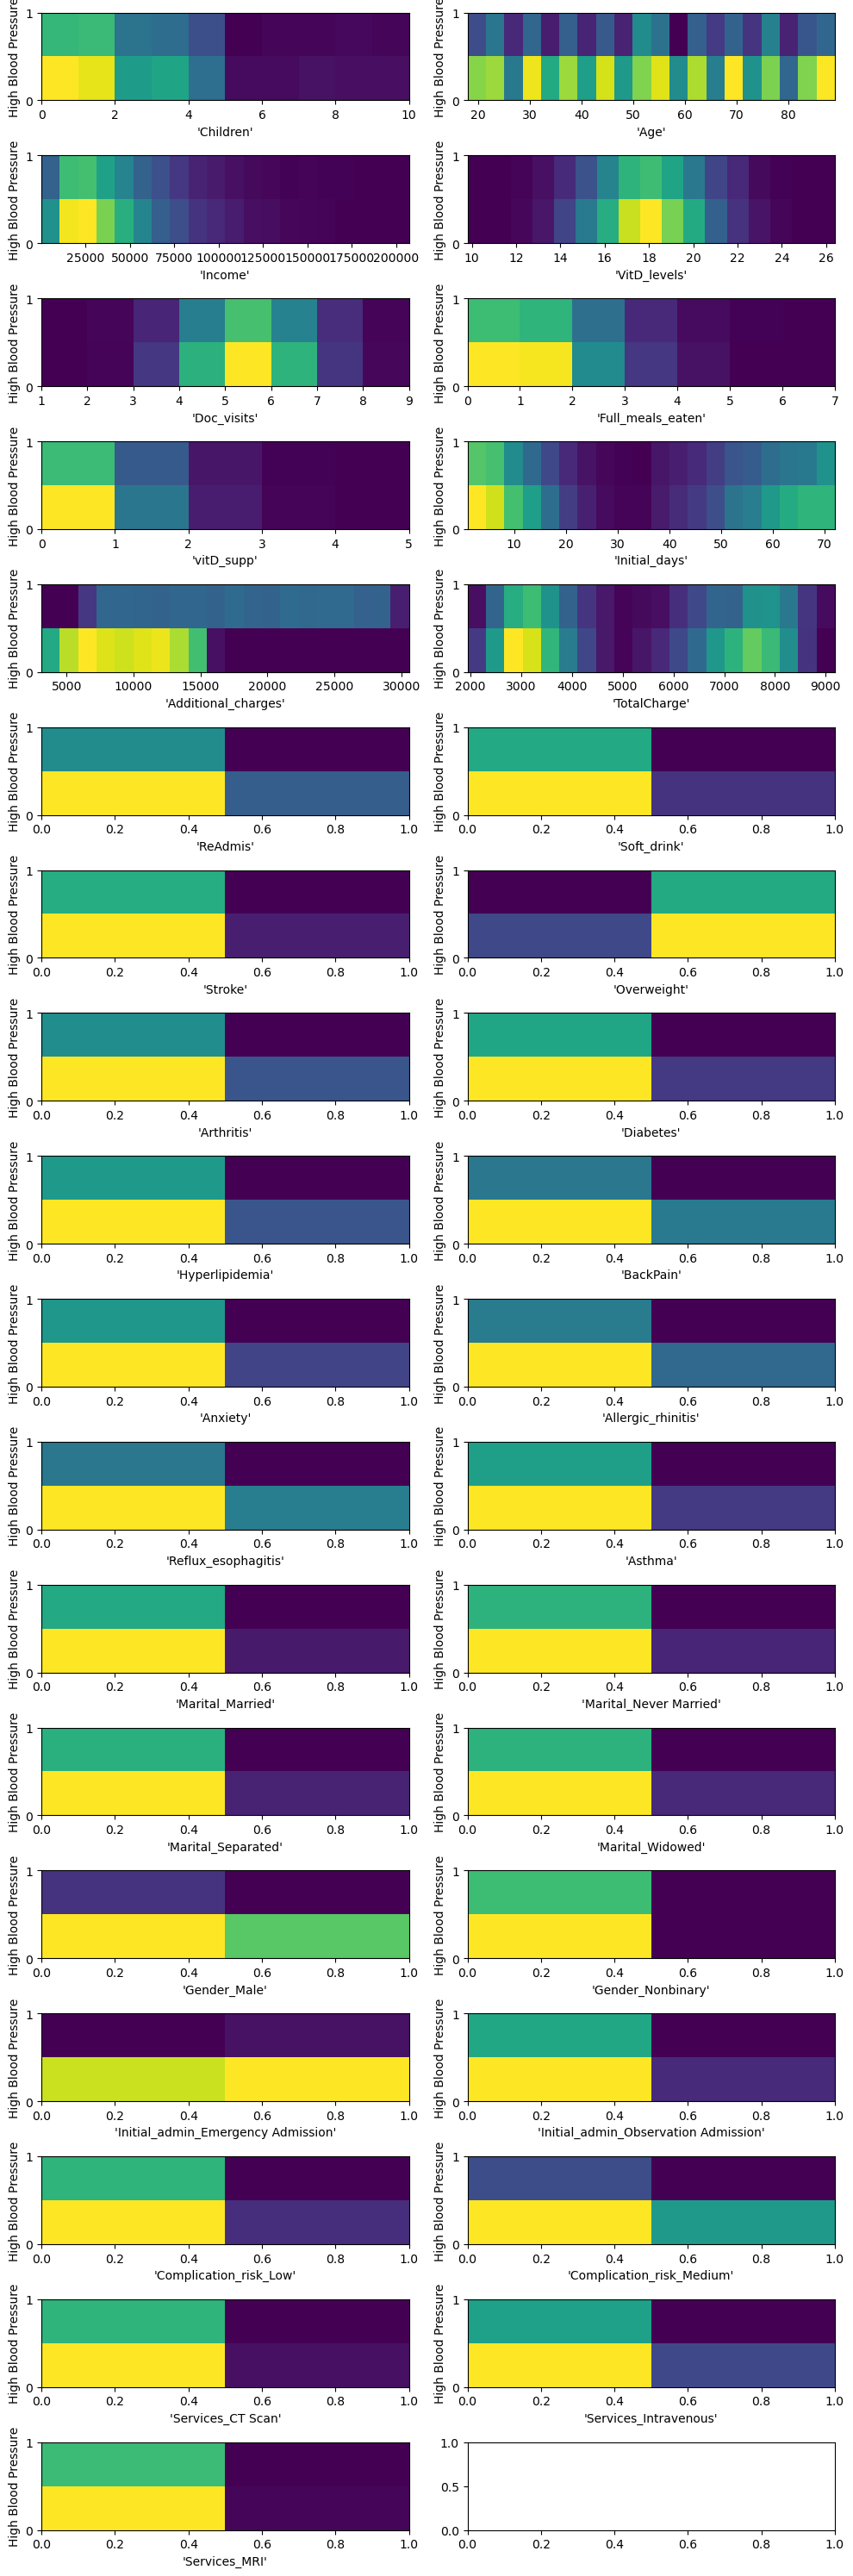

In [13]:
# Bivariate Histograms for Independent Variables

num_cols = 2

fig, axs = plt.subplots(math.ceil(len(var_independent) / num_cols), num_cols, figsize=(10, 30), tight_layout=True)

for i, var in enumerate(var_independent):
    # Min 2, Max 20 x bins
    x_bins = math.ceil(max(min(df[var].max() - df[var].min(), 20), 2))
    axs[i // num_cols, i % num_cols].hist2d(data=df, x=var, y='HighBlood', bins=[x_bins, 2])
    name = f'{var=}'.split('=')[1]
    axs[i // num_cols, i % num_cols].set_xlabel(name)
    axs[i // num_cols, i % num_cols].set_ylabel("High Blood Pressure");
    axs[i // num_cols, i % num_cols].set_yticks(range(0, 2))
    
plt.show()

### Bivariate Observations
1. Additional Charges have High Blood Pressure spread across the entire range, but no High Blood Pressure is concentrated in the bottom corner. Perhaps more people have no High Blood Pressure, and have lower additional charges, while fewer people have high blood pressure and have costs that are usually higher.
2. This is also the case with Total Charges.

## CSV Export

In [14]:
# Export Data
df.to_csv('clean.csv', index=False)

# Model Comparison and Analysis

## Initial Logistic Regression Model

In [15]:
y = df['HighBlood']
X = df[var_independent].assign(const=1)

model = sm.Logit(y, X)
results = model.fit()

print(results.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              HighBlood   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9964
Method:                           MLE   Df Model:                           35
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                   1.000
Time:                        22:20:09   Log-Likelihood:            -8.2527e-05
converged:                      False   LL-Null:                       -6764.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Children                               -0.2085     56.519     -0.004      0.997    -110.984   

C:\Users\Aaron\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Reduction Justification

The original model had many features that were correlated and ones that provided little explanation for the variance of high blood pressure. To clean up this model the first step was to remove highly correlated features. This is done by getting the variance inflation factor (VIF) of each feature. Features with VIF values greater than 10 are removed from the model. In our case, these were TotalCharge, VitD_levels, Age, and Doc_visits. Next, any features with values greater than our 0.05 alpha value are removed since these are not significant in our model. This included Initial_admin_Observation Admission, Initial_admin_Emergency Admission, BackPain, Stroke, Marital_Widowed, Gender_Nonbinary, Diabetes, Reflux_esophagitis, Initial_days, Services_Intravenous, Hyperlipidemia, Services_MRI, Gender_Male, Children, Income, Complication_risk_Low, Marital_Separated, Soft_drink, ReAdmis, Arthritis, Asthma, Anxiety, Allergic_rhinitis, Marital_Married, Marital_Never Married, vitD_supp, Services_CT Scan, and Full_meals_eaten.

The only features left are not heavily correlated with each other, and ones that provide significance to the model. These will be the only ones important for answering our Research Question.

In [16]:
# vif_removal() is a recursive function that will remove features with VIF > 10.
# The VIF check has to be ran after each feature removal, which necessitates the recursive function
def vif_removal():
    # Create Dataframe for VIF Info
    vif_df = pd.DataFrame()
    vif_df["feature"] = df[var_independent].columns
    vif_df["VIF"] = [variance_inflation_factor(df[var_independent].values, i) for i in range(len(df[var_independent].columns))]
    
    # Highest VIF Variable Data
    highest = vif_df.sort_values('VIF').round(2).tail(1)
    highest_vif = int(highest.VIF)
    highest_column = str(list(highest.feature)[0])
    
    if highest_vif > 10:
        print(highest_column, " has a VIF Value of: ", highest_vif, " and will be removed from the dataset.")
        
        # Drop from Dataframe and from variable list, then run function again
        df.drop(highest_column, axis='columns', inplace=True)
        var_independent.remove(highest_column)
        vif_removal()
    else:
        print("All Features with VIF values > 10 Have been removed.")
        return False

# While VIF > 10, remove
remove = True

while remove:
    remove = vif_removal()

TotalCharge  has a VIF Value of:  826  and will be removed from the dataset.
VitD_levels  has a VIF Value of:  33  and will be removed from the dataset.
Age  has a VIF Value of:  15  and will be removed from the dataset.
Doc_visits  has a VIF Value of:  13  and will be removed from the dataset.
All Features with VIF values > 10 Have been removed.


In [17]:
y = df['HighBlood']
X = df[var_independent].assign(const=1)

model = sm.Logit(y, X)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.411870
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              HighBlood   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9968
Method:                           MLE   Df Model:                           31
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3912
Time:                        22:20:13   Log-Likelihood:                -4118.7
converged:                       True   LL-Null:                       -6764.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Children                               -0.0093      0.013 

In [18]:
# Significant Variables < 0.05 (alpha value)
# Insignificant Variables are dropped from the DataFrame and removed from the list of independent variables

# p_removal() is a recursive function that will remove features with pvals > 0.05.
# The Pval check has to be ran after each feature removal, which necessitates the recursive function
def p_removal():   
    # New Model after VIF Evaluation
    y = df['HighBlood']
    X = df[var_independent].assign(const=1)

    model = sm.OLS(y, X)
    results = model.fit()

    pvals = results.pvalues.sort_values()
    highest = pvals.tail(1)
    highest_name = list(highest.index)[0]
    highest_value = highest.values[0]
    
    if highest_value > 0.05:
        print(highest_name, " has a P Value of: ", highest_value.round(2), " and will be removed from the dataset.")
        
        # Drop from Dataframe and from variable list, then run function again
        df.drop(highest_name, axis='columns', inplace=True)
        var_independent.remove(highest_name)
        p_removal()
    else:
        print("All Features with P values > 0.05 Have been removed.")
        return False

# While pval > 0.05, remove
remove = True

while remove:
    remove = p_removal()

vitD_supp  has a P Value of:  0.96  and will be removed from the dataset.
Marital_Married  has a P Value of:  0.94  and will be removed from the dataset.
Anxiety  has a P Value of:  0.9  and will be removed from the dataset.
Services_CT Scan  has a P Value of:  0.87  and will be removed from the dataset.
Allergic_rhinitis  has a P Value of:  0.84  and will be removed from the dataset.
Full_meals_eaten  has a P Value of:  0.71  and will be removed from the dataset.
Arthritis  has a P Value of:  0.68  and will be removed from the dataset.
ReAdmis  has a P Value of:  0.66  and will be removed from the dataset.
Asthma  has a P Value of:  0.64  and will be removed from the dataset.
Gender_Male  has a P Value of:  0.64  and will be removed from the dataset.
Soft_drink  has a P Value of:  0.63  and will be removed from the dataset.
Marital_Never Married  has a P Value of:  0.54  and will be removed from the dataset.
Marital_Separated  has a P Value of:  0.59  and will be removed from the data

## Final Model

Prior to creating the Final Model, a training and test dataset will be be created to allow easy evaluation later.

In [19]:
y = df['HighBlood']
X = df[var_independent].assign(const=1)

# Test and training split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)

In [20]:
model = sm.Logit(y_train, X_train)
results = model.fit()

print(results.summary())

Optimization terminated successfully.
         Current function value: 0.414381
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              HighBlood   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7994
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3882
Time:                        22:20:13   Log-Likelihood:                -3315.1
converged:                       True   LL-Null:                       -5418.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Additional_charges                      0.0003   8.06e-06 

## Model Comparison

The comparison metric I have chosen for this evaluation is the Psuedo R-squared metric. A standard R-squared value cannot be applied to a logistic regression model, since we are modeling likelihoods, not direct values. Pseudo R-squared attempts to mimic the R-squared metric. However, since the error variance is different for each predicted value, it cannot be used analogously to an R-squared metric. We should have no problem using the metric to compare models on the same data, the metric just falls apart when comparing models on different data. (IBM)

When we compare Psuedo R-squared values, we still see the original model has a value of 1.00 and our final model has a value of 0.3882. After some research, this is because of the warning we are getting on the original model, "Complete Separation: The results show that there is complete separation.". Complete Separation meanings the dependent variable for our function separates (between 0 and 1) at an exact value for one of our independent variables. After some research, it turns out the TotalCharge variable is the culprit. The removal of these variables removes this separation. This means the first model's R-squared value of 1.0 is not an accurate metric. (OARC)

To simplify, the Psuedo R-squared metric does not have to be 1.0 for a perfect model, and the original model's Psuedo R-squared value does not hold water by itself. To accurately assess the accuracy of the final model we will need to run a training and test split against the model and evaluate the accuracy of predictions.

## Evaluation

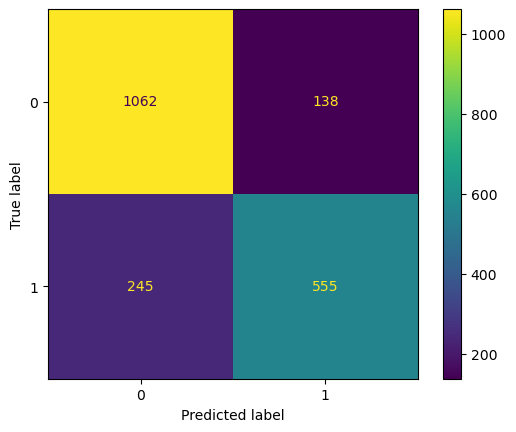

Accuracy: 0.81
Precision: 0.8
Sensitivity (Recall): 0.69
Specificity: 0.88
F-score: 0.74


In [21]:
# Predictions from Model using Training data to Fit,
# Values are returned as continuous between 0-1, and rounded to match binary High Blood Pressure Value
y_pred = round(results.predict(X_test))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

# All Confusion Matrix Metrics
print(f'Accuracy: {round(metrics.accuracy_score(y_test, y_pred),2)}')
print(f'Precision: {round(metrics.precision_score(y_test, y_pred),2)}')
print(f'Sensitivity (Recall): {round(metrics.recall_score(y_test, y_pred),2)}')
print(f'Specificity: {round(metrics.recall_score(y_test, y_pred, pos_label=0),2)}')
print(f'F-score: {round(metrics.f1_score(y_test, y_pred),2)}')

## Executable Code

I am not sure if the above code snippets suffice. If not an additional python file "d208_task2_e3.py" has been included.
To run the file, numpy, pandas, matplotlib, seaborn, and statsmodels libraries have to be installed. That file executes all the above code snippets.

# Part V: Data Summary and Implications

## Results

### Equation

ln (p / (1 - p)) = - 4.9522 + 0.0003 ( Additional_charges ) - 0.1532 ( Stroke ) + 0.1382 ( Overweight ) + 0.1776 ( Initial_admin_Observation Admission ) + 0.1455 ( Complication_risk_Medium )

### Practical Interpretation

A Patients chance of having High Blood Pressure can be interpreted as the following:

- All things constant, for each extra dollar in additional charges, the patient will be 0.03% more likely to have High Blood Pressure.

- All things constant, if the patient has a Stroke, the patient will be 15.32% more likely to have High Blood Pressure.

- All things constant, if the patient is overweight, the patient will be 13.82% more likely to have High Blood Pressure.

- All things constant, if the patient's initial admission is an Observation Admission, the patient will be 17.76% more likely to have High Blood Pressure.

- All things constant, if the patient has a medium complication risk, the patient will be 14.55% more likely to have High Blood Pressure.

### Significance

This model has some practical and statistical significance; however, I have concerns with its practicality. We had 4 features that were statistically significant to our model, but our model was not accurate and effective at taking into account all variance in the model. The model could only predict with a ~81% accuracy, which while good, in my opinion, is not high enough to make financial or health-related suggestions. Additionally, practically speaking I'm not sure how useful the additional charges feature is to the model, since this value is calculated during/after a visit. It can not be used to predict or estimate high blood pressure in patients. By the time you have their additional charges, you will already have their blood pressure.

### Limitations

- While logistic regression could not be used, I do believe a continuous variable for Blood Pressure would interesting to compare to this boolean option. It may provide more insight into patient health.
- There is a similar problem with overweight. In my experience weights are usually broken down into underweight, normal, overweight, obese, and morbidly obese. I think this categorical feature or a continuous BMI value would provide more insight, especially since being underweight can have negative health consequences as well.

# Recommendations

At this time I cannot recommend any course of action when it comes to answering our question. I do not believe this model is good enough to be used to make any decisions, and I do not believe we can make any conclusions on features related to high blood pressure. It does appear that more research should be done in comparing overweight and high blood pressure, there may be a connection there.

# Presentation

https://youtu.be/LWugYhTZ4xc

# Web Sources

Model Building:

Van den Broeck, M. (n.d.). Intro to Regression with statsmodels in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-regression-with-statsmodels-in-python

Van den Broeck, M. (n.d.). Intermediate Regression with statsmodels in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/intermediate-regression-with-statsmodels-in-python

Vestuto, J. (n.d.). Intro to Linear Modeling in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-linear-modeling-in-python

Verbiest, N. (n.d.). Intro to Predictive Analytics in Python. Datacamp. Retrieved December 12, 2023, from https://app.datacamp.com/learn/courses/introduction-to-predictive-analytics-in-python

Python: Intro to MLR / OLS in statmodels.api. (n.d.). www.youtube.com. Retrieved December 12, 2023, from https://www.youtube.com/watch?v=0-fkgpK2knA

Model Evaluation:

FAQ What is complete or quasi-complete separation in logistic/probit regression and how do we deal with them? (n.d.). Stats.oarc.ucla.edu. Retrieved December 12, 2023, from https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/

Middleton, K. (n.d.). D208 - Webinar: Getting Started with D208 Part II (October). Panopto. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=09b8fdbb-a374-452b-ba53-af39001ff3f3

Pseudo R Square. (n.d.). Www.ibm.com. https://www.ibm.com/docs/en/spss-statistics/saas?topic=model-pseudo-r-square

Python Machine Learning - Confusion Matrix. (n.d.). Www.w3schools.com. https://www.w3schools.com/python/python_ml_confusion_matrix.asp

Segall, B. F., Jason. (2022, October 6). Why R2 is not a measure of goodness-of-fit. Quantics Biostatistics. https://www.quantics.co.uk/blog/r-we-squared-yet-why-r-squared-is-a-poor-metric-for-goodness-of-fit/

VIF and get_Dummies:

Sewell, W. (n.d.). D208 Predictive Modeling Webinar - Episode 1. https://westerngovernorsuniversity-my.sharepoint.com/:p:/g/personal/william_sewell_wgu_edu/ER_vJMbYtxJGpxImpZ0DUQcBoVcORYKanFVKNKFcEXkRow?rtime=_ZkGUN_W2kg

# Sources

US Census Bureau (2020, February 5). Marital Status in the United States. The United States Census Bureau. https://www.census.gov/library/visualizations/interactive/marital-status-in-united-states.html